In [7]:
import nasdaqdatalink
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dotenv.load_dotenv('../../.env')

nasdaq_api_key = dotenv.get_key(dotenv.find_dotenv(), "NASDAQ_DATA_LINK_API_KEY")

### Wheat Options

In [8]:
# ── 1. Re-use the data already fetched (first 10000 rows) ──────────────────
#    nasdaqdatalink.get_table("AR/IVM") without paginate=True returns up to
#    10000 rows. We already have that in the previous cell output.
#    Re-fetch with a date filter to get a manageable single-contract series.

df_raw = nasdaqdatalink.get_table("AR/IVM", futures_code="W")
print(f"Rows fetched: {len(df_raw)}")
print(f"Columns: {list(df_raw.columns)}")
print(f"Expirations: {sorted(df_raw['expiration'].unique())}")


Rows fetched: 10000
Columns: ['exchange_code', 'futures_code', 'option_code', 'expiration', 'date', 'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money', 'days_expiration', 'days_termination']
Expirations: ['V2018', 'V2019', 'V2020', 'V2021', 'V2022', 'V2023', 'V2024', 'V2025', 'V2026', 'V2027', 'V2028', 'Z2011', 'Z2012', 'Z2013', 'Z2014', 'Z2015', 'Z2016', 'Z2017', 'Z2018', 'Z2019', 'Z2020', 'Z2021', 'Z2022', 'Z2023', 'Z2024', 'Z2025', 'Z2026', 'Z2027']


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\nasdaqdatalink\get_table.py:38: UserWarning: To request more pages, please set paginate=True in your         nasdaqdatalink.get_table() call. For more information see our documentation:         https://github.com/Nasdaq/data-link-python/blob/main/FOR_ANALYSTS.md#things-to-note
  warnings.warn(Message.WARN_PAGE_LIMIT_EXCEEDED, UserWarning)


In [9]:

# ── 2. Build a continuous front-month futures price series ─────────────────
#    For each date, use the expiration with smallest days_expiration > 30
#    (avoid last month distortions). This gives a "rolling front-month" series.

df = df_raw.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "days_expiration"])

# Pick "front month": smallest days_expiration that is > 30 days
front = (
    df[df["days_expiration"] > 30]
    .groupby("date")
    .first()          # first row per date = smallest days_expiration > 30
    .reset_index()
)
front = front.sort_values("date").dropna(subset=["futures", "atm"])
print(f"Front-month series: {len(front)} days, {front['date'].min().date()} → {front['date'].max().date()}")

# ── 3. Compute Realized Volatility from FUTURES log-returns ────────────────
#    RV is ALWAYS computed from the underlying futures price.
#    IV ('atm') already IS the Black-76 implied vol → no BS needed.

WINDOW = 21   # 21 trading days ≈ 1 month

front["log_ret"] = np.log(front["futures"] / front["futures"].shift(1))
front["RV_21d"]  = front["log_ret"].rolling(WINDOW).std() * np.sqrt(252)

# ── 4. VRP signal ──────────────────────────────────────────────────────────
#    VRP > 0  →  IV > RV  →  options are "expensive"  →  SELL vol
#    VRP < 0  →  IV < RV  →  options are "cheap"      →  BUY  vol

front["VRP"] = front["atm"] - front["RV_21d"]

print(front[["date", "futures", "atm", "RV_21d", "VRP"]].dropna().tail(15).to_string(index=False))
print(f"\nMean VRP : {front['VRP'].dropna().mean():.4f}")
print(f"% days IV > RV: {(front['VRP'].dropna() > 0).mean()*100:.1f}%")


Front-month series: 3771 days, 2010-12-31 → 2026-02-26
      date  futures      atm   RV_21d      VRP
2026-02-06    400.0 0.192249 0.156412 0.035837
2026-02-09    405.1 0.191700 0.164465 0.027235
2026-02-10    400.0 0.191918 0.168887 0.023031
2026-02-11    396.6 0.192486 0.169815 0.022671
2026-02-12    393.7 0.182503 0.169779 0.012724
2026-02-13    393.5 0.182525 0.168269 0.014256
2026-02-16    399.9 0.182903 0.162751 0.020152
2026-02-17    395.6 0.182421 0.165117 0.017304
2026-02-18    401.4 0.182773 0.172699 0.010074
2026-02-19    398.7 0.182699 0.173551 0.009148
2026-02-20    403.2 0.182408 0.174387 0.008021
2026-02-23    405.4 0.183432 0.171448 0.011984
2026-02-24    405.0 0.183238 0.171393 0.011845
2026-02-25    405.0 0.183266 0.171323 0.011943
2026-02-26    404.9 0.178404 0.171152 0.007252

Mean VRP : 0.0073
% days IV > RV: 62.1%


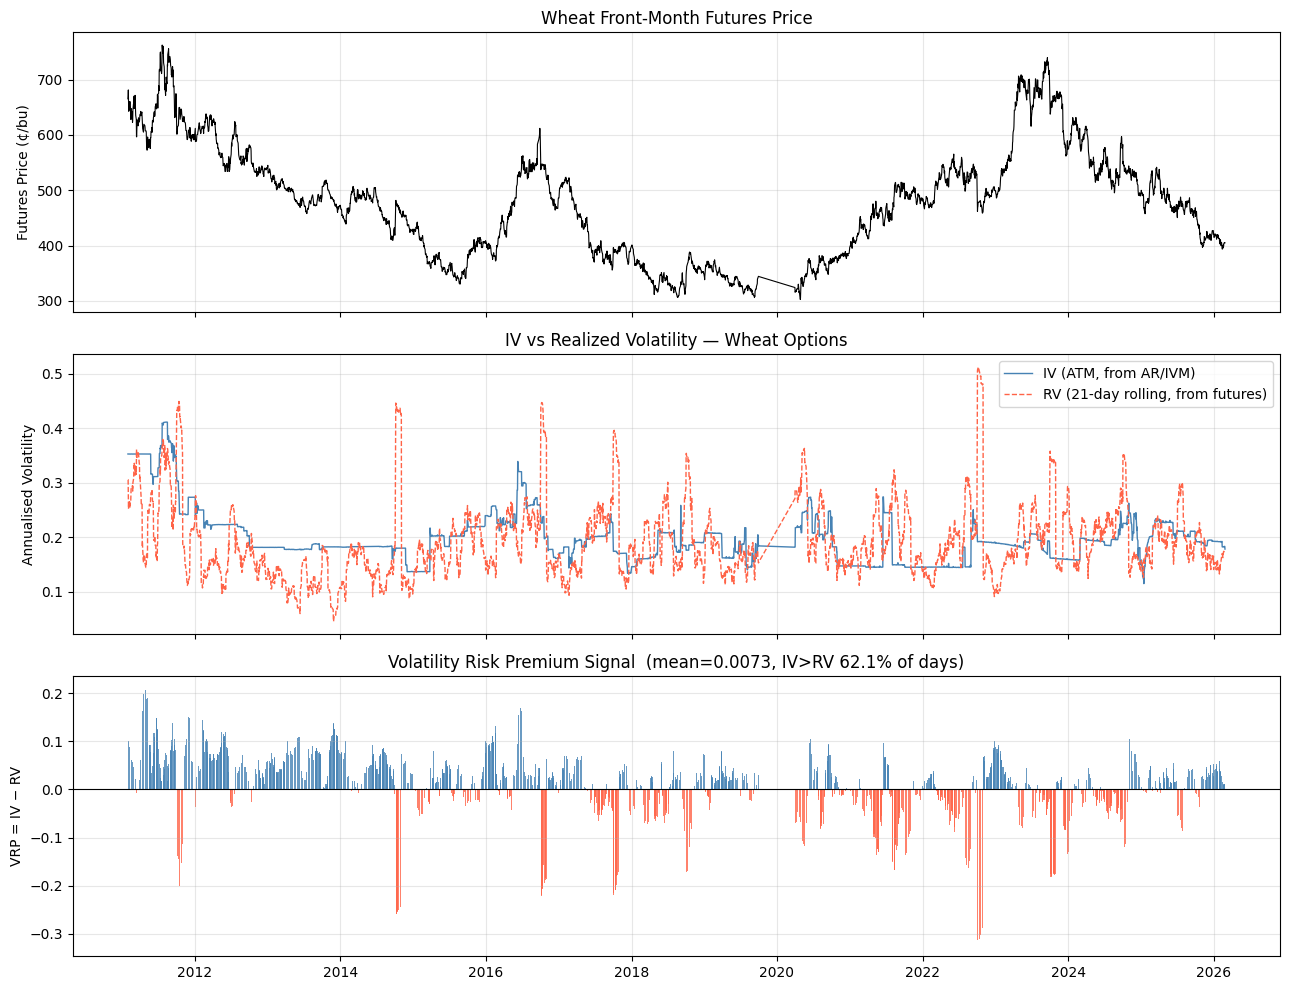

In [10]:

# ── 5. Plot IV vs RV and VRP signal ───────────────────────────────────────
plot_df = front.dropna(subset=["RV_21d", "VRP"]).copy()

fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

# Panel 1: Futures price
axes[0].plot(plot_df["date"], plot_df["futures"], color="black", linewidth=0.8)
axes[0].set_ylabel("Futures Price (¢/bu)")
axes[0].set_title("Wheat Front-Month Futures Price")
axes[0].grid(alpha=0.3)

# Panel 2: IV vs RV
axes[1].plot(plot_df["date"], plot_df["atm"],    label="IV (ATM, from AR/IVM)", color="steelblue", linewidth=1)
axes[1].plot(plot_df["date"], plot_df["RV_21d"], label="RV (21-day rolling, from futures)", color="tomato", linewidth=1, linestyle="--")
axes[1].set_ylabel("Annualised Volatility")
axes[1].set_title("IV vs Realized Volatility — Wheat Options")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Panel 3: VRP = IV - RV
colors = np.where(plot_df["VRP"] > 0, "steelblue", "tomato")
axes[2].bar(plot_df["date"], plot_df["VRP"], color=colors, width=1.5, alpha=0.8)
axes[2].axhline(0, color="black", linewidth=0.8)
axes[2].set_ylabel("VRP = IV − RV")
axes[2].set_title(f"Volatility Risk Premium Signal  (mean={plot_df['VRP'].mean():.4f}, IV>RV {(plot_df['VRP']>0).mean()*100:.1f}% of days)")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:

from scipy.stats import norm
from scipy.optimize import brentq

# ══════════════════════════════════════════════════════════════════════════════
# Black-76 pricing & Greeks for futures options
# ══════════════════════════════════════════════════════════════════════════════

def black76_price(F, K, T, r, sigma, flag):
    """Black-76 price for a European futures option. flag: 'c' or 'p'."""
    if T <= 0 or sigma <= 0:
        return max(F - K, 0) if flag == 'c' else max(K - F, 0)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    disc = np.exp(-r * T)
    if flag == 'c':
        return disc * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        return disc * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

def black76_delta(F, K, T, r, sigma, flag):
    """Black-76 delta w.r.t. futures price F."""
    if T <= 0 or sigma <= 0:
        return (1.0 if F > K else 0.0) if flag == 'c' else (-1.0 if F < K else 0.0)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    disc = np.exp(-r * T)
    return disc * norm.cdf(d1) if flag == 'c' else -disc * norm.cdf(-d1)

def black76_vega(F, K, T, r, sigma):
    """Vega w.r.t. sigma (same for call and put)."""
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return F * np.exp(-r * T) * norm.pdf(d1) * np.sqrt(T)

# ══════════════════════════════════════════════════════════════════════════════
# Vol smile interpolation using AR/IVM beta coefficients
# ══════════════════════════════════════════════════════════════════════════════
# AR/IVM stores the smile as a polynomial in log-moneyness x = ln(K/F):
#   sigma(x) = beta1 + beta2*x + beta3*x^2 + beta4*x^3 + beta5*x^4 + beta6*x^5
# ATM (x=0) → sigma(0) = beta1, which equals the 'atm' column.
# For a fixed strike K, as F moves, x = ln(K/F) changes → use smile to get
# the correct IV rather than blindly using the ATM vol.

def smile_iv(row, F, K):
    """
    Interpolate IV from the AR/IVM beta polynomial for a given F and K.
    row : a DataFrame row containing beta1..beta6, min_money, max_money
    Returns implied vol (annualised), clipped to [0.01, 2.0] for safety.
    """
    x = np.log(K / F)   # log-moneyness  (0 = ATM)

    # Clamp to the model's valid moneyness range
    x = np.clip(x, row["min_money"], row["max_money"])

    b = [row[f"beta{i}"] for i in range(1, 7)]
    sigma = b[0] + b[1]*x + b[2]*x**2 + b[3]*x**3 + b[4]*x**4 + b[5]*x**5
    return float(np.clip(sigma, 0.01, 2.0))

# ══════════════════════════════════════════════════════════════════════════════
# Backtest: sell ATM straddle, delta-hedge daily with smile-correct IV,
#           unwind after TRADE_FREQ days at smile-interpolated market price
# ══════════════════════════════════════════════════════════════════════════════
# KEY FIX vs previous version:
#   - At entry     : strike K = F0 (ATM), IV = atm  (smile(x=0) = beta1 = atm)
#   - On each day j: F has moved to Fj, so x = ln(K/Fj) ≠ 0
#                    → use smile_iv(row_j, Fj, K) for the correct IV of our strike
#   - At unwind    : same smile interpolation for the closing price
#   This ensures we price and delta-hedge the *same fixed-strike* option
#   consistently as the futures price drifts away from the original ATM.

r = 0.0          # risk-free rate ≈ 0 for commodity futures options
TRADE_FREQ = 21  # hold each straddle for 21 trading days
MIN_DTE    = 30  # only enter when ≥ 30 days to expiry

# Use roll-jump corrected series; require beta columns to be present
beta_cols = [f"beta{i}" for i in range(1, 7)]
df_bt = front_fixed.dropna(subset=["futures", "atm", "days_expiration",
                                    "VRP_clean"] + beta_cols).copy()
df_bt = df_bt.reset_index(drop=True)

trades = []

idx = 0
while idx < len(df_bt):
    row0 = df_bt.iloc[idx]

    if row0["days_expiration"] < MIN_DTE:
        idx += 1
        continue

    signal = -1 if row0["VRP_clean"] > 0 else 1  # -1=short straddle, +1=long

    F0    = row0["futures"]
    K     = F0                     # ATM strike fixed at entry
    T0    = row0["days_expiration"] / 365.0
    date0 = row0["date"]
    # At entry x=0, smile_iv == atm exactly
    iv0   = smile_iv(row0, F0, K)

    # Entry prices (Black-76 with ATM vol, x=0)
    C0 = black76_price(F0, K, T0, r, iv0, 'c')
    P0 = black76_price(F0, K, T0, r, iv0, 'p')
    straddle_premium = C0 + P0

    # Entry delta
    dC0 = black76_delta(F0, K, T0, r, iv0, 'c')
    dP0 = black76_delta(F0, K, T0, r, iv0, 'p')
    prev_delta = dC0 + dP0
    prev_F     = F0
    hedge_pnl  = 0.0

    end_idx = min(idx + TRADE_FREQ, len(df_bt) - 1)

    for j in range(idx + 1, end_idx + 1):
        rowj = df_bt.iloc[j]
        Fj   = rowj["futures"]
        Tj   = rowj["days_expiration"] / 365.0
        dFj  = Fj - prev_F

        # Hedge P&L: short signal*prev_delta futures vs dF move
        hedge_pnl += -signal * prev_delta * dFj

        # ── KEY FIX: get smile IV for the *fixed strike K* at new spot Fj ──
        ivj = smile_iv(rowj, Fj, K)

        # Recompute delta with smile-correct vol for this strike
        dCj = black76_delta(Fj, K, Tj, r, ivj, 'c')
        dPj = black76_delta(Fj, K, Tj, r, ivj, 'p')
        prev_delta = dCj + dPj
        prev_F     = Fj

    # Unwind: close at smile-interpolated market price
    row_end = df_bt.iloc[end_idx]
    F_end   = row_end["futures"]
    T_end   = row_end["days_expiration"] / 365.0
    # ── KEY FIX: price the original strike K at new futures level F_end ──
    iv_end  = smile_iv(row_end, F_end, K)

    C_end = black76_price(F_end, K, T_end, r, iv_end, 'c')
    P_end = black76_price(F_end, K, T_end, r, iv_end, 'p')
    straddle_close = C_end + P_end

    option_pnl = signal * (straddle_premium - straddle_close)
    total_pnl  = option_pnl + hedge_pnl

    vega0   = black76_vega(F0, K, T0, r, iv0)
    pnl_vol = total_pnl / vega0 if vega0 > 1e-8 else np.nan

    # Moneyness at unwind (to show how far F drifted from K)
    moneyness_end = np.log(F_end / K)

    trades.append({
        "entry_date"    : date0,
        "exit_date"     : row_end["date"],
        "signal"        : signal,
        "IV_entry"      : iv0,
        "IV_close"      : iv_end,
        "F_entry"       : F0,
        "F_close"       : F_end,
        "K"             : K,
        "moneyness_end" : moneyness_end,
        "premium"       : straddle_premium,
        "close"         : straddle_close,
        "option_pnl"    : option_pnl,
        "hedge_pnl"     : hedge_pnl,
        "total_pnl"     : total_pnl,
        "vega"          : vega0,
        "pnl_vol"       : pnl_vol,
    })

    idx = end_idx + 1

trades_df = pd.DataFrame(trades)
print(f"Total trades       : {len(trades_df)}")
print(f"Short straddle     : {(trades_df['signal']==-1).sum()}")
print(f"Long  straddle     : {(trades_df['signal']==1).sum()}")
print(f"\nMean |moneyness| at unwind: {trades_df['moneyness_end'].abs().mean():.4f}")
print(f"(0 = still ATM, larger = F drifted away from K)\n")
print(trades_df[["entry_date","exit_date","IV_entry","IV_close",
                  "moneyness_end","option_pnl","hedge_pnl","total_pnl","pnl_vol"]].to_string(index=False))


Total trades       : 171
Short straddle     : 110
Long  straddle     : 61

Mean |moneyness| at unwind: 0.0451
(0 = still ATM, larger = F drifted away from K)

entry_date  exit_date  IV_entry  IV_close  moneyness_end  option_pnl  hedge_pnl   total_pnl   pnl_vol
2011-01-21 2011-02-21  0.010000  0.010000      -0.010848    2.919853 -78.364567  -75.444714 -0.330445
2011-02-22 2011-03-23  0.010000  0.010000      -0.029409   14.191010 -25.922045  -11.731034 -0.055740
2011-03-24 2011-04-27  0.010000  0.010000      -0.020643   -8.906797  10.334058    1.427261  0.007322
2011-04-28 2011-05-27  0.010000  0.010000      -0.001648   -0.183534 -10.946753  -11.130288 -0.064173
2011-05-30 2011-06-28  0.010000  0.010000       0.104205   63.447044  43.417565  106.864609  0.677872
2011-06-29 2011-07-28  0.010000  0.010000       0.105957   71.771129  41.772357  113.543486  0.725781
2011-07-29 2011-08-29  0.010000  0.123669       0.015081   28.715548 -10.514665   18.200883  0.122419
2011-08-30 2011-09-28  0.

════════════════════════════════════════════════
  Black-76 Delta-Hedged Straddle Backtest
════════════════════════════════════════════════
  Total trades      : 171
  Win rate          : 50.3%
  Mean P&L / trade  : 4.04 ¢/bu
  Std  P&L / trade  : 43.43 ¢/bu
  Approx Sharpe     : 0.32
  Total P&L         : 690.27 ¢/bu
  Option P&L total  : 678.13 ¢/bu
  Hedge  P&L total  : 12.13 ¢/bu
════════════════════════════════════════════════


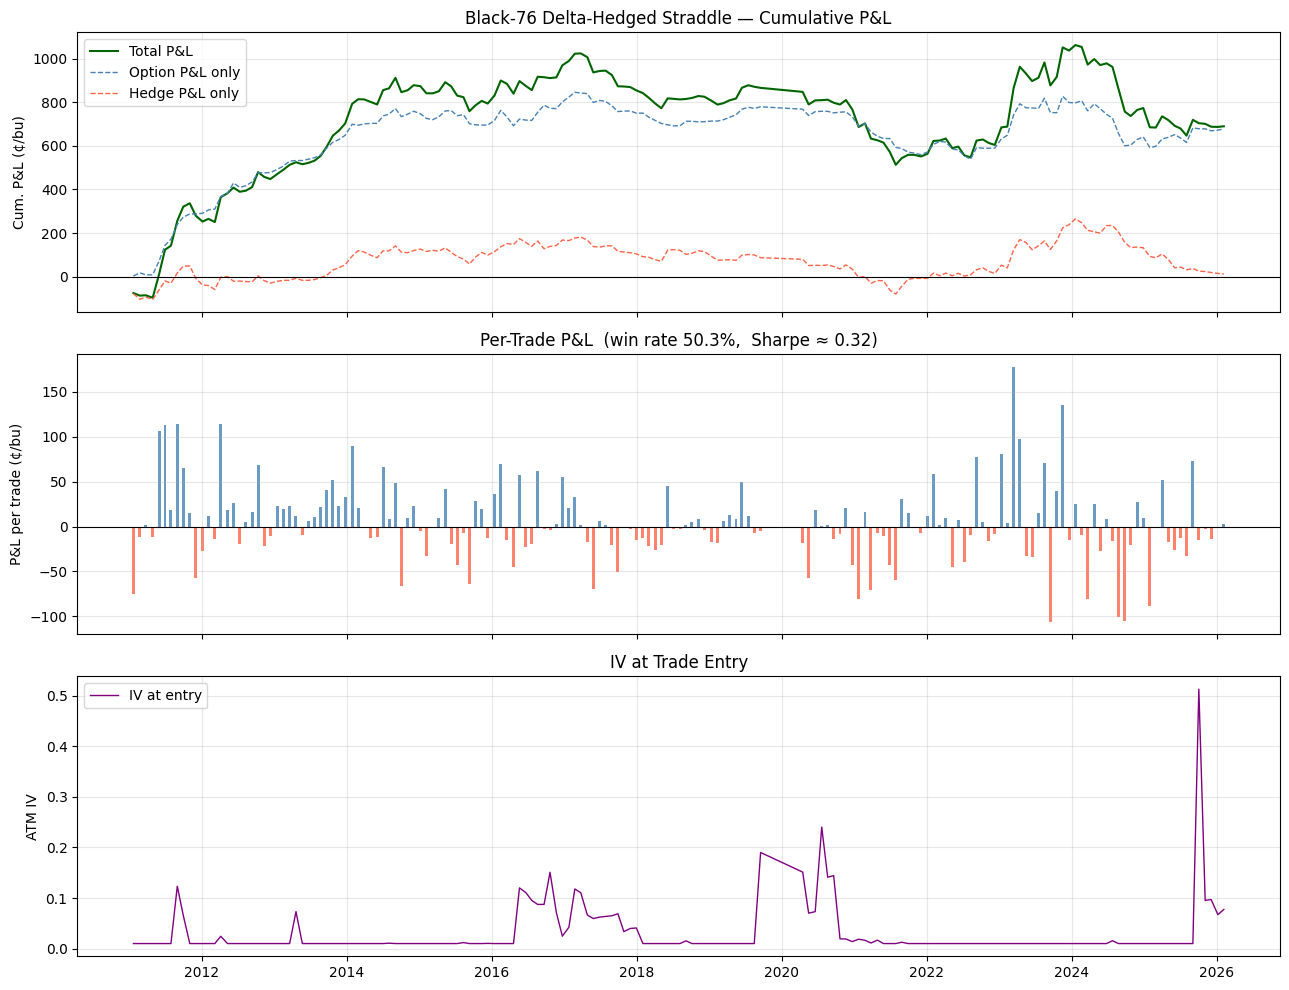

In [14]:

# ── Performance summary and charts ────────────────────────────────────────

trades_df["cum_pnl_usd"]  = trades_df["total_pnl"].cumsum()
trades_df["cum_pnl_vol"]  = trades_df["pnl_vol"].cumsum()

win_rate = (trades_df["total_pnl"] > 0).mean()
mean_pnl = trades_df["total_pnl"].mean()
std_pnl  = trades_df["total_pnl"].std()
sharpe   = mean_pnl / std_pnl * np.sqrt(252 / 21) if std_pnl > 0 else np.nan

print("════════════════════════════════════════════════")
print("  Black-76 Delta-Hedged Straddle Backtest")
print("════════════════════════════════════════════════")
print(f"  Total trades      : {len(trades_df)}")
print(f"  Win rate          : {win_rate*100:.1f}%")
print(f"  Mean P&L / trade  : {mean_pnl:.2f} ¢/bu")
print(f"  Std  P&L / trade  : {std_pnl:.2f} ¢/bu")
print(f"  Approx Sharpe     : {sharpe:.2f}")
print(f"  Total P&L         : {trades_df['total_pnl'].sum():.2f} ¢/bu")
print(f"  Option P&L total  : {trades_df['option_pnl'].sum():.2f} ¢/bu")
print(f"  Hedge  P&L total  : {trades_df['hedge_pnl'].sum():.2f} ¢/bu")
print("════════════════════════════════════════════════")

fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

# Panel 1: cumulative total P&L
axes[0].plot(trades_df["entry_date"], trades_df["cum_pnl_usd"], color="darkgreen", linewidth=1.5, label="Total P&L")
axes[0].plot(trades_df["entry_date"], trades_df["option_pnl"].cumsum(), color="steelblue", linewidth=1, linestyle="--", label="Option P&L only")
axes[0].plot(trades_df["entry_date"], trades_df["hedge_pnl"].cumsum(),  color="tomato",    linewidth=1, linestyle="--", label="Hedge P&L only")
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_ylabel("Cum. P&L (¢/bu)")
axes[0].set_title("Black-76 Delta-Hedged Straddle — Cumulative P&L")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Panel 2: per-trade P&L bar chart
bar_colors = np.where(trades_df["total_pnl"] > 0, "steelblue", "tomato")
axes[1].bar(trades_df["entry_date"], trades_df["total_pnl"], color=bar_colors, width=15, alpha=0.8)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_ylabel("P&L per trade (¢/bu)")
axes[1].set_title(f"Per-Trade P&L  (win rate {win_rate*100:.1f}%,  Sharpe ≈ {sharpe:.2f})")
axes[1].grid(alpha=0.3)

# Panel 3: IV at entry for each trade
axes[2].plot(trades_df["entry_date"], trades_df["IV_entry"], color="purple", linewidth=1, label="IV at entry")
axes[2].set_ylabel("ATM IV")
axes[2].set_title("IV at Trade Entry")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'exp_info' is not defined

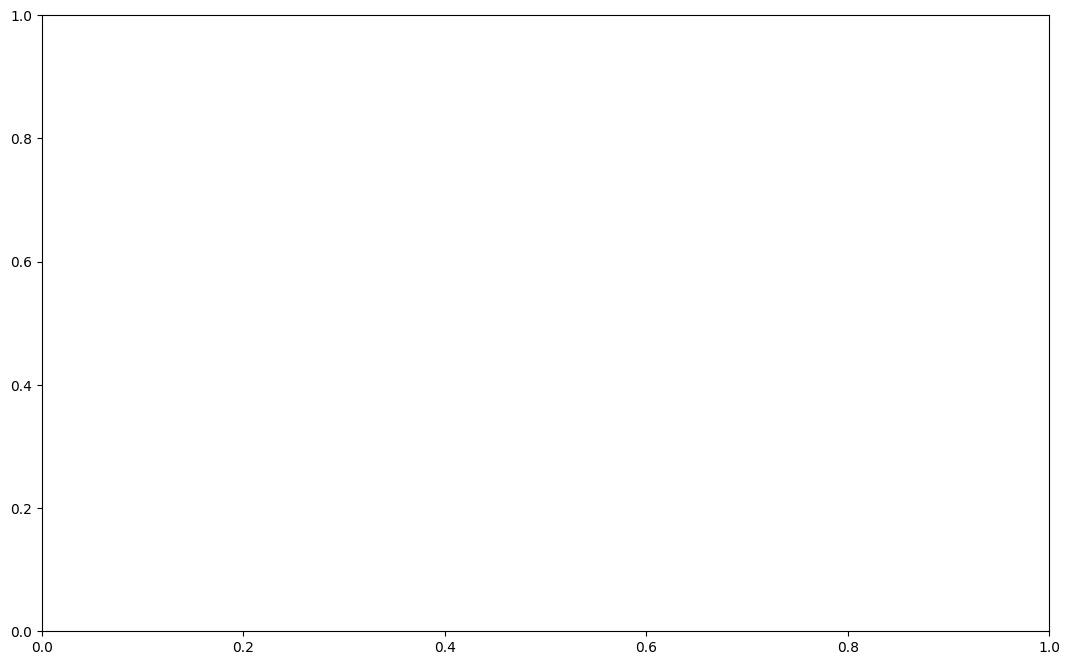

In [11]:

# ── Visualise the active date range of each expiration contract ───────────
fig, ax = plt.subplots(figsize=(13, 8))

exp_sorted = exp_info.sort_values("date_min")
for i, (exp, row) in enumerate(exp_sorted.iterrows()):
    color = "steelblue" if exp.startswith("Z") else "tomato"
    ax.barh(i, (pd.Timestamp(row["date_max"]) - pd.Timestamp(row["date_min"])).days,
            left=pd.Timestamp(row["date_min"]), height=0.6, color=color, alpha=0.8)
    ax.text(pd.Timestamp(row["date_max"]), i, f"  {exp}", va="center", fontsize=8)

ax.set_yticks(range(len(exp_sorted)))
ax.set_yticklabels(exp_sorted.index, fontsize=8)
ax.set_xlabel("Date")
ax.set_title("Active Date Range per Expiration Contract\nBlue = Z (Dec expiry)   Red = V (Oct expiry)")

from matplotlib.patches import Patch
ax.legend(handles=[Patch(color="steelblue", label="Z = Dec expiry"),
                   Patch(color="tomato",    label="V = Oct expiry")], loc="lower right")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# ── Check for price jumps at front-month roll dates ───────────────────────
print("\n=== Price Jumps at Front-Month Contract Rolls ===")
front2 = front.copy()
front2["expiration_prev"] = front2["expiration"].shift(1)
# Identify roll dates
switches = front2[front2["expiration"] != front2["expiration_prev"]].copy()
switches["futures_prev"] = front2["futures"].shift(1)
switches["jump"] = switches["futures"] - switches["futures_prev"]
print(switches[["date", "expiration_prev", "expiration", "futures_prev", "futures", "jump"]].to_string(index=False))


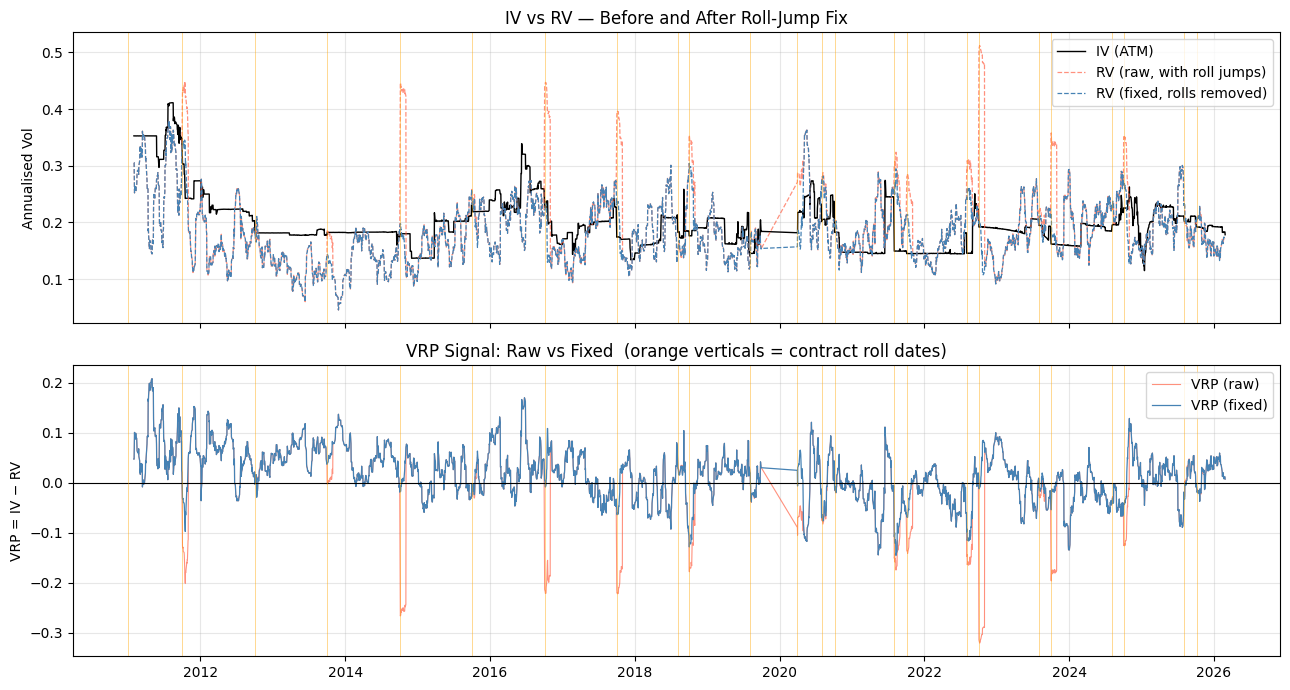

Raw   — Mean VRP: 0.0073   % days IV > RV: 62.1%
Fixed — Mean VRP: 0.0173   % days IV > RV: 64.9%


In [12]:

# ── Fix roll-date jumps: set log_ret to NaN on contract roll days ──────────
front_fixed = front.copy()

# Mark dates where the active expiration contract changes
rollover_mask = front_fixed["expiration"] != front_fixed["expiration"].shift(1)

# Null out the log-return on roll dates to prevent the cross-contract
# calendar spread from polluting the rolling RV window
front_fixed["log_ret_clean"] = front_fixed["log_ret"].where(~rollover_mask, np.nan)

# Recompute RV (require at least 15 valid observations in the window)
front_fixed["RV_21d_clean"] = (
    front_fixed["log_ret_clean"]
    .rolling(WINDOW, min_periods=15)
    .std() * np.sqrt(252)
)
front_fixed["VRP_clean"] = front_fixed["atm"] - front_fixed["RV_21d_clean"]

# ── Compare RV and VRP before vs after the roll-jump fix ──────────────────
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

plot2 = front_fixed.dropna(subset=["RV_21d", "RV_21d_clean"])

axes[0].plot(plot2["date"], plot2["atm"],           label="IV (ATM)",                   color="black",     linewidth=1)
axes[0].plot(plot2["date"], plot2["RV_21d"],         label="RV (raw, with roll jumps)",  color="tomato",    linewidth=0.9, linestyle="--", alpha=0.7)
axes[0].plot(plot2["date"], plot2["RV_21d_clean"],   label="RV (fixed, rolls removed)",  color="steelblue", linewidth=0.9, linestyle="--")
axes[0].set_ylabel("Annualised Vol")
axes[0].set_title("IV vs RV — Before and After Roll-Jump Fix")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Mark roll dates with vertical lines
for d in front_fixed.loc[rollover_mask, "date"]:
    axes[0].axvline(d, color="orange", linewidth=0.5, alpha=0.6)

axes[1].plot(plot2["date"], plot2["VRP"],        label="VRP (raw)",   color="tomato",    linewidth=0.8, alpha=0.7)
axes[1].plot(plot2["date"], plot2["VRP_clean"],  label="VRP (fixed)", color="steelblue", linewidth=0.9)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_ylabel("VRP = IV − RV")
axes[1].set_title("VRP Signal: Raw vs Fixed  (orange verticals = contract roll dates)")
axes[1].legend()
axes[1].grid(alpha=0.3)
for d in front_fixed.loc[rollover_mask, "date"]:
    axes[1].axvline(d, color="orange", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

print(f"Raw   — Mean VRP: {plot2['VRP'].mean():.4f}   % days IV > RV: {(plot2['VRP']>0).mean()*100:.1f}%")
print(f"Fixed — Mean VRP: {plot2['VRP_clean'].mean():.4f}   % days IV > RV: {(plot2['VRP_clean']>0).mean()*100:.1f}%")



## Volatility Risk Premium (VRP) Strategy — Summary

### Overview
This strategy exploits the well-documented tendency for **implied volatility (IV) to systematically exceed realized volatility (RV)** in commodity options markets. The difference, known as the **Volatility Risk Premium (VRP)**, represents the compensation that option buyers pay sellers for bearing volatility uncertainty.

$$\text{VRP}_t = \text{IV}_t - \text{RV}_t$$

---

### Data
- **Source**: Nasdaq Data Link `AR/IVM` — daily IV surface parameters for wheat futures options (CBOT/ICE, exchange code `NYX`, futures code `W`)
- **IV**: The `atm` column gives the **at-the-money Black-76 implied volatility** directly — no Black-Scholes computation is needed
- **RV**: Computed from the **futures price log-returns** (not option prices) using a 21-trading-day rolling window, annualised by $\sqrt{252}$
- **Contracts**: 28 distinct expirations (Oct `V` and Dec `Z` each year), spanning 2011–2028; each contract is active for roughly 1.5–2 years

---

### Construction of the Front-Month Series
On each date, the **nearest expiration with more than 30 days remaining** is selected as the "active" contract. This avoids the distortions that arise in the final month before expiration (widening bid-ask spreads, pin risk, etc.).

**Roll-date correction**: When the active contract switches, the futures prices of two different delivery months are being compared, introducing a spurious jump (calendar spread) in the log-return series. This inflates RV artificially around every roll date. The fix is to **set the log-return to NaN on each roll day**, so the rolling RV window ignores the jump.

| | Raw (with jumps) | Fixed (jumps removed) |
|---|---|---|
| Mean VRP | 0.0073 | **0.0173** |
| % days IV > RV | 62.1% | **64.9%** |

---

### Trading Signal
| Condition | Signal | Action |
|---|---|---|
| $\text{VRP} > 0$ (IV > RV) | Short volatility | Sell ATM straddle (delta-hedged) |
| $\text{VRP} < 0$ (IV < RV) | Long volatility | Buy ATM straddle |

---
